In [18]:
from unittest import skipUnless
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [ ]:
# !pip install pyarrow

In [ ]:
# !pip install fastparquet

In [30]:
def prepare_df(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
        df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"])
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)
        
    df['duration'] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)
    df = df.loc[(df['duration']>=1) & (df['duration']<=60),:]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df
    
        

In [31]:
df_train = prepare_df('./data/green_tripdata_2022-01.parquet')
df_val = prepare_df('./data/green_tripdata_2022-02.parquet')

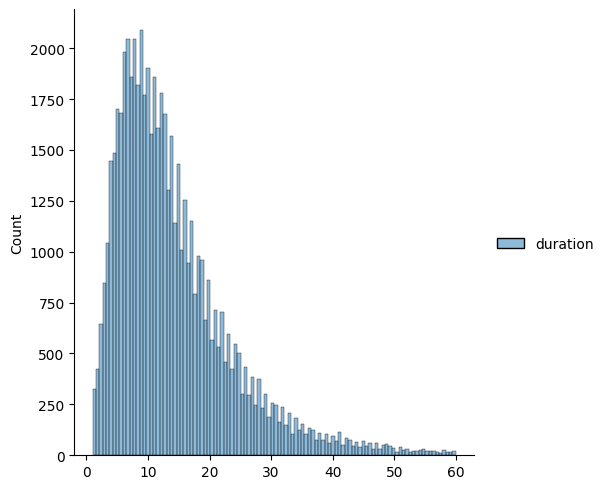

In [33]:
# Exploratory analysis

sns.displot(df_train.loc[((df_train['duration']>=1) & (df_train['duration']<=60)), ['duration']])

In [34]:
len(df_train), len(df_val)

(59603, 66097)

In [35]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]


In [36]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [37]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)


6.92893123431991

In [48]:
lr = Lasso(0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

# Estimate RMSE
mean_squared_error(y_val, y_pred, squared = False)

7.475775217343405

In [49]:
import pickle

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [46]:
lr = Ridge(0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

9.987741338419413